In [1]:
import decord
from config import SniffBat2Dataset
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2
from utils import utils
import json
import scipy
import toml
from tqdm import tqdm

## Load calibration video

Extract stationary frames with no movement.

In [6]:
date = '231007'
bat_id = '32622'
data_path = f'/home/batlab/mnt/server4/users/KevinQi/datasets/GridBat/32622/small_cage/raw/{date}'
calibration_path = os.path.join(data_path, 'calibration/cameras')

calibration_frames_path = os.path.join(data_path.replace('raw','processed'),'calibration/cameras')

In [8]:
video_paths = SniffBat2Dataset.get_video_paths(calibration_path)

['Basler_acA2040-55um__24260140__20231007_144407797.mp4']
['Basler_acA2040-55um__23584894__20231007_144400452.mp4']
['Basler_a2A1920-160umBAS__40243954__20231007_144325541.mp4']
['Basler_acA800-510um__23521662__20231007_144525993.mp4']
['Basler_acA800-510um__23354674__20231007_144512170.mp4']
['Basler_a2A1920-160umBAS__40243958__20231007_144328165.mp4']
['Basler_acA800-510um__23521660__20231007_144519432.mp4']
['Basler_a2A1920-160umBAS__40243959__20231007_144329315.mp4']


In [9]:
vr = decord.VideoReader(video_paths['front2'])
motion = []
for i in tqdm(range(0,len(vr)-1)):
    frame1 = vr[i].asnumpy()
    frame2 = vr[i+1].asnumpy()
    diff_frame = cv2.absdiff(src1=frame1, src2=frame2)
    motion.append(np.mean(diff_frame))
    
    #plt.close()

100%|█| 11099/11099 [00:50<00:00, 219.


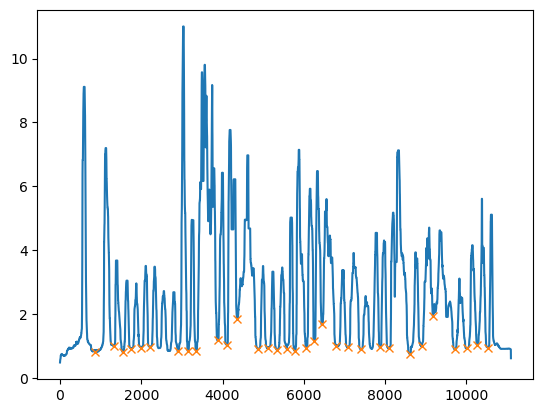

In [10]:
smooth_motion = scipy.signal.medfilt(motion,91)

peaks, _ = scipy.signal.find_peaks(50-smooth_motion, height=48, prominence=2, distance=100)
plt.plot(smooth_motion)
plt.plot(peaks, smooth_motion[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [11]:
for view in SniffBat2Dataset.VIEWS:
    vpath = video_paths[view]
    utils.extract_video_at_frames(vpath, os.path.join(calibration_frames_path,view), peaks)

## Run Multical

Run multical in each data folder (manual):

multical calibrate --boards ../../../paddleboard.yaml

## Convert multical to anipose format

In [12]:
def multical_to_anipose(multical_calibration_json, VIEWS):
    """
    Convert mutlical calibration to anipose calibration format
    """
    with open(multical_calibration_json,'r') as f:
        calibration = json.load(f)
    
    toml_dict = {}
    i = 0
    for view in VIEWS:
        cam_cal = calibration['cameras'][view]

        cam_pose_keys = calibration['camera_poses'].keys()
        key = [s for s in cam_pose_keys if view in s][0]

        cam_poses = calibration['camera_poses'][key]
        img_size = cam_cal['image_size']
        K = cam_cal['K']
        distortions = cam_cal['dist']
        R_mat = cam_poses['R']
        R_vec,_ = cv2.Rodrigues(np.array(R_mat))
        print(R_vec)
        T = cam_poses['T']
        
        cam_id = f'cam_{i}'
        toml_dict[cam_id] = {}
        toml_dict[cam_id]['name'] = view
        toml_dict[cam_id]['size'] = img_size
        toml_dict[cam_id]['matrix'] = K
        toml_dict[cam_id]['distortions'] = distortions
        toml_dict[cam_id]['rotation'] = R_vec
        toml_dict[cam_id]['translation'] = T
        i += 1
    toml_dict['metadata'] = {}
    
    return toml_dict

In [14]:
mult_cal_json = os.path.join(data_path.replace('raw','processed'), 'calibration/cameras', f'{date}_calibration.json')

In [11]:
## Mutli to anipose conversion
mult_cal_json = os.path.join('../data/221108_calibration.json')

toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS)
with open(os.path.join('../data/221108_calibration.toml'), 'w') as f:
    toml_str = toml.dump(toml_dict, f)

[[0.]
 [0.]
 [0.]]
[[-0.46027296]
 [-0.04988033]
 [ 0.0283142 ]]
[[ 0.98221757]
 [-0.24556565]
 [ 0.06426974]]
[[ 0.99424264]
 [ 0.29409017]
 [-0.24398333]]
[[ 0.68543284]
 [ 1.24433614]
 [-1.56603907]]
[[ 0.39907696]
 [ 1.48450662]
 [-1.74038034]]
[[ 0.58043532]
 [-1.51999261]
 [ 1.59979089]]
[[ 0.8707491 ]
 [-1.05400556]
 [ 1.41944891]]


In [9]:
%ls ../data

221108_calibration.json*      32626/       ir_marker_training_data/  yolov5/
221130_32626_extra_frames/    config.py    tests/
221130_32626_extra_frames_2/  __init__.py  via/


In [10]:
toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS)
with open(os.path.join(data_path,'calibration','cameras','calibration.toml'), 'w') as f:
    toml_str = toml.dump(toml_dict, f)

[[0.]
 [0.]
 [0.]]
[[-0.45861536]
 [-0.05515081]
 [ 0.02560125]]
[[ 0.97534294]
 [-0.24346379]
 [ 0.06731017]]
[[ 0.99636149]
 [ 0.29322901]
 [-0.23978648]]
[[ 0.68812068]
 [ 1.25197447]
 [-1.5649493 ]]
[[ 0.39868491]
 [ 1.49028041]
 [-1.74292183]]
[[ 0.58039108]
 [-1.50901932]
 [ 1.59985389]]
[[ 0.85177661]
 [-1.04172967]
 [ 1.43305848]]
[[0.]
 [0.]
 [0.]]
[[ 0.97534294]
 [-0.24346379]
 [ 0.06731017]]
[[ 0.68812068]
 [ 1.25197447]
 [-1.5649493 ]]
[[ 0.58039108]
 [-1.50901932]
 [ 1.59985389]]
[[-0.45861536]
 [-0.05515081]
 [ 0.02560125]]
[[ 0.99636149]
 [ 0.29322901]
 [-0.23978648]]
[[ 0.39868491]
 [ 1.49028041]
 [-1.74292183]]
[[ 0.85177661]
 [-1.04172967]
 [ 1.43305848]]
[[ 0.97534294]
 [-0.24346379]
 [ 0.06731017]]
[[ 0.99636149]
 [ 0.29322901]
 [-0.23978648]]
[[ 0.68812068]
 [ 1.25197447]
 [-1.5649493 ]]
[[ 0.39868491]
 [ 1.49028041]
 [-1.74292183]]
[[ 0.58039108]
 [-1.50901932]
 [ 1.59985389]]
[[ 0.85177661]
 [-1.04172967]
 [ 1.43305848]]


In [24]:
toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS[2:])
with open(os.path.join(data_path,'calibration','cameras','group_side_calibration.toml'), 'w') as f:
        toml_str = toml.dump(toml_dict, f)

[[ 0.97759716]
 [-0.24119008]
 [ 0.07017873]]
[[ 1.00230269]
 [ 0.29420344]
 [-0.23650333]]
[[ 0.69880998]
 [ 1.25933801]
 [-1.56153122]]
[[ 0.40617122]
 [ 1.49516482]
 [-1.741138  ]]
[[ 0.5805232 ]
 [-1.50353856]
 [ 1.6005015 ]]
[[ 0.85341065]
 [-1.03826352]
 [ 1.43477784]]


In [16]:
SniffBat2Dataset.VIEWS[6:8]

['left1', 'left2']

In [13]:
toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS[2:4])
with open(os.path.join(data_path,'calibration','cameras','group_front_calibration.toml'), 'w') as f:
        toml_str = toml.dump(toml_dict, f)

[[ 0.96662799]
 [-0.23983301]
 [ 0.06710883]]
[[ 0.99262185]
 [ 0.2974749 ]
 [-0.24093061]]


In [15]:
toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS[4:6])
with open(os.path.join(data_path,'calibration','cameras','group_right_calibration.toml'), 'w') as f:
        toml_str = toml.dump(toml_dict, f)

[[ 0.68451821]
 [ 1.24579557]
 [-1.5655079 ]]
[[ 0.39578811]
 [ 1.4880464 ]
 [-1.7436956 ]]


In [17]:
toml_dict = multical_to_anipose(mult_cal_json, SniffBat2Dataset.VIEWS[6:8])
with open(os.path.join(data_path,'calibration','cameras','group_left_calibration.toml'), 'w') as f:
        toml_str = toml.dump(toml_dict, f)

[[ 0.57810298]
 [-1.51369244]
 [ 1.59507541]]
[[ 0.85191628]
 [-1.05091659]
 [ 1.42787005]]


# Extract frames

In [42]:
date = '221130'
bat_id = '32626'
data_path = f'../data/{bat_id}/raw/{date}'
calibration_path = os.path.join(data_path, 'cameras')

video_paths = SniffBat2Dataset.get_video_paths(calibration_path)

['Basler_acA2040-55um__24260140__20221130_111515233.mp4']
['Basler_acA2040-55um__23584894__20221130_111514106.mp4']
['Basler_a2A1920-160umBAS__40243954__20221130_111511789.mp4']
['Basler_acA800-510um__23521662__20221130_111518111.mp4']
['Basler_acA800-510um__23354674__20221130_111516257.mp4']
['Basler_a2A1920-160umBAS__40243958__20221130_111512573.mp4']
['Basler_acA800-510um__23521660__20221130_111517231.mp4']
['Basler_a2A1920-160umBAS__40243959__20221130_111513316.mp4']


In [44]:
frames = [28699, 38026, 53747, 58014, 84663, 90815, 127353, 136693, 145449, 152423, 198740, 203198, 217470, 233410, 264319, 284165, 320246, 326841, 334532, 340372, 369114, 374276, 380923, 404818, 31635, 43984, 44399, 44830, 45504, 45867, 50316, 56825, 57198, 57622, 58356, 59366, 75268, 75724, 89491, 90303, 122650, 123623, 143329, 161783, 162052]

In [45]:
import random
random.shuffle(frames)
frames[:10]
frames[10:]

[127353,
 28699,
 233410,
 38026,
 217470,
 90815,
 380923,
 56825,
 143329,
 264319,
 75268,
 198740,
 44830,
 136693,
 43984,
 334532,
 203198,
 122650,
 58014,
 152423,
 45504,
 161783,
 84663,
 123623,
 31635,
 374276,
 59366,
 90303,
 44399,
 369114,
 145449,
 284165,
 45867,
 58356,
 340372]

In [46]:
SniffBat2Dataset.VIEWS

['bottom1',
 'bottom2',
 'front1',
 'front2',
 'right1',
 'right2',
 'left1',
 'left2']

In [49]:
for view in SniffBat2Dataset.VIEWS[2:]:
    vpath = video_paths[view]
    utils.extract_video_at_frames(vpath, '../32626_221130_train' , frames[10:], prefix=f'32626_221130_{view}')